[← Back to Index](https://makeabilitylab.github.io/physcomp/signals)

# Overview
In this Notebook, you will learn some introductory concepts to automatic feature selection and hyperparameter tuning. We assume that you have already read over and completed the exercises in the [Introduction to Supervised Learning Notebook](https://makeabilitylab.github.io/physcomp/signals/gesturerec/featurebased/index.html) for gesture recognition.

## Resources
- [Tuning Hyperparameters](https://scikit-learn.org/stable/modules/grid_search.html), Scikit-learn documentation
- [Improving the Random Forest in Python](https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd), Will Koehrsen, Jan 2018
- [Hyper-Parameter Tuning and Model Selection, Like a Movie Star](https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d68), Caleb Neale, Jun 2019
- [How to Tune Algorithm Parameters with Scikit-Learn](https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/), Jason Brownlee, Aug 2019
- [Introduction to Machine Learning with Python](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/), Andreas C. Müller & Sarah Guido, Oct 2016

## About this notebook

This Notebook was designed and written by Professor Jon E. Froehlich at the University of Washington along with feedback from students. It is made available freely online as an [open educational resource](https://en.wikipedia.org/wiki/Open_educational_resources) at the teaching website: https://makeabilitylab.github.io/physcomp/. 

The [website](https://github.com/makeabilitylab/physcomp), [Notebook code](https://github.com/makeabilitylab/signals), and [Arduino code](https://github.com/makeabilitylab/arduino) are all open source using the MIT license.

Please file a GitHub Issue or Pull Request for changes/comments or email me directly.

# Imports

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os
import math
import itertools
from IPython.display import display_html

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.vis as grvis
import gesturerec.signalproc as grsignalproc

from gesturerec.data import SensorData
from gesturerec.data import GestureSet

# Scikit-learn stuff
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Import Pandas: https://pandas.pydata.org/
import pandas as pd

# Import Seaborn: https://seaborn.pydata.org/
import seaborn as sns

# Utility functions

In [2]:
def filter_correlated_features(df, filter_threshold = 0.95):
    '''Filters out features with a Pearson correlation coefficient > filter_threshold
    
       Based on: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    '''
    # Take the abs value so both negative and positive correlations are mapped from 0 to 1
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than filter_threshold
    to_drop = [column for column in upper.columns if any(upper[column] > filter_threshold)]
    print("Dropping", to_drop)
    filtered_df = df.drop(columns=to_drop)
    return filtered_df

def classify_df(input_df, clf, scaler, feature_selector, random_state = None):
    # Drop the features like 'trial_num' 'gesturer' that are not actually input features
    df = input_df.copy()
    df_trial_indices = df.pop('trial_num')
    df_gesturer = df.pop('gesturer')
    df_gesture = df.pop('gesture') # ground truth labels

    # Filter out highly correlated features
    filtered_df = filter_correlated_features(df, 0.95)
    print(f"Total features remaining: {len(filtered_df.columns)}")

    # Setup an 80/20 split for training and testing stratified around gesture type
    X = filtered_df # input features
    y = df_gesture # ground truth labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

    # Train the model and compute a baseline classification score
    clf.fit(X_train, y_train)
    baseline_score = clf.score(X_test, y_test)

    # Now scale data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Compute scaled data score
    clf.fit(X_train_scaled, y_train) # retrain model
    scaled_data_score = clf.score(X_test_scaled, y_test)

    print("Before scaling variance:")
    display(pd.DataFrame(X_train.var(), columns=["Variance"]).T)

    print("After scaling variance:")
    scaled_df = pd.DataFrame(X_train_scaled, columns = filtered_df.columns)
    display(pd.DataFrame(scaled_df.var(), columns=["Variance"]).T)

    # Apply variance threshold
    feature_selector.fit(X_train_scaled, y_train)
    X_train_selected = feature_selector.transform(X_train_scaled)
    X_test_selected = feature_selector.transform(X_test_scaled)

    # Visualize filtered features
    feature_selector_mask = feature_selector.get_support()
    print(f"Feature elimination mask: {feature_selector_mask}") # Columns that are False were eliminated
    print(f"Num of eliminated features: {len(np.where(feature_selector_mask == False)[0])}")
    print(f"The eliminated features: {scaled_df.columns[~feature_selector_mask]}")
    print(f"Feature indices to eliminate (in black below): {np.where(feature_selector_mask == False)}")
    #fig = plt.figure(figsize=(15, 0.5)) # to change matshow figsize https://stackoverflow.com/a/43023727
    #plt.matshow(~feature_selector_mask.reshape(1, -1), cmap='gray_r', fignum=fig.number)
    plt.matshow(~feature_selector_mask.reshape(1, -1), cmap='gray_r')
    plt.xlabel("Feature index")
    plt.yticks(())
    plt.show()
    print(f"The final set of input features: {scaled_df.columns[feature_selector_mask]}")

    # Compute final score (with filtered, scaled data)
    clf.fit(X_train_selected, y_train) # retrain model
    scaled_and_filtered_score = clf.score(X_test_selected, y_test)

    print("---")
    print(f"Baseline accuracy: {baseline_score:.3f}")
    print(f"Scaled accuracy: {scaled_data_score:.3f}")
    print(f"Scaled and filtered accuracy: {scaled_and_filtered_score:.3f}")
    

# Load the data
These cells are the same as for the [Shape Matching](https://makeabilitylab.github.io/physcomp/signals/gesturerec/shapebased/index.html) notebook. You should not need to edit them, only run them.

In [3]:
# Load the data
#root_gesture_log_path = './GestureLogsADXL335'
root_gesture_log_path = './GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
if selected_gesture_set is None:
    # if the selected gesture set is still None
    selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['AGestures', 'AlexandraGestures', 'AlexisGestures', 'AnjaliGestures', 'BrettGestures', 'BryanGestures', 'ClayGestures', 'DustinGestures', 'EmmaGestures', 'JaeHGestures', 'JasonGestures', 'JonGestures', 'JuliaBGestures', 'JustinGestures', 'MattCGestures', 'MikaelGestures', 'NanGestures', 'NeilGestures', 'NickGestures', 'NooseGestures', 'OjasviGestures', 'Paf2Gestures', 'SamuelRGestures', 'ShaunGestures', 'StacyGestures', 'ThweidGestures', 'WolfGestures']
Creating a GestureSet object for path './GestureLogs\AGestures'
Found 55 csv files in ./GestureLogs\AGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 t

Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 889 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.5s

Creating a GestureSet object for path './GestureLogs\JuliaBGestures'
Found 55 csv files in ./GestureLogs\JuliaBGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Fou

Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Midair Zorro 'Z'' Trial 0 with 239 sensor events.
Avg samples/sec across 55 sensor files: 91.7
Avg sample length across 55 sensor files: 1.6s

Creating a GestureSet object for path './GestureLogs\ThweidGestures'
Found 55 csv files in ./GestureLogs\ThweidGestures
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Custom'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'Custom' Trial 2 with 281 sensor events.
Avg samples/sec ac

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [4]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 27 gesture sets:
 AGestures with 55 trials
 AlexandraGestures with 55 trials
 AlexisGestures with 55 trials
 AnjaliGestures with 55 trials
 BrettGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 DustinGestures with 55 trials
 EmmaGestures with 55 trials
 JaeHGestures with 55 trials
 JasonGestures with 55 trials
 JonGestures with 55 trials
 JuliaBGestures with 55 trials
 JustinGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 NanGestures with 55 trials
 NeilGestures with 55 trials
 NickGestures with 55 trials
 NooseGestures with 55 trials
 OjasviGestures with 55 trials
 Paf2Gestures with 55 trials
 SamuelRGestures with 55 trials
 ShaunGestures with 55 trials
 StacyGestures with 55 trials
 ThweidGestures with 55 trials
 WolfGestures with 55 trials
The selected gesture set is: JonGestures


# Preprocess the data

You may want to revisit how you preprocess your data. You can create one or more processed versions of each signal. For now, we'll just smooth the data using a sliding window.

In [5]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    
    # TODO: write your preprocessing code here. We'll do something very simple for now,
    
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    return processed_signal

def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)

for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

# Feature extraction
This code is largely the same as as the [Introduction to Supervised Learning](https://makeabilitylab.github.io/physcomp/signals/gesturerec/featurebased/index.html) Notebook but adds in a `include_dummy_data` variable. If True, we inject "dummy" variables into the feature set to demonstrate and evaluate the feature selection algorithms.

In [6]:
def extract_features_from_gesture_sets(gesture_sets, include_custom_gesture=True, include_dummy_data=False):
    '''
    Extracts features for all provided gesture sets.
    
    Parameters:
        gesture_sets: collection of GestureSet objects
        include_custom_gesture: if True, includes the custom gesture. Otherwise, not.
        include_dummy_data: if True, includes dummy features (for illustrative purposes)
    '''
    list_of_feature_vectors = []
    column_headers = []
    for gesture_set in gesture_sets:
        (feature_vectors, cols) = extract_features_from_gesture_set(gesture_set, include_custom_gesture)
        list_of_feature_vectors += feature_vectors
        column_headers = cols
    return (list_of_feature_vectors, column_headers)

def extract_features_from_gesture_set(gesture_set, include_custom_gesture=True, include_dummy_data=False):
    '''
    Extracts features from the gesture set
    '''
    list_of_feature_vectors = []
    column_headers = None
    
    gesture_names = None
    
    if include_custom_gesture:
        gesture_names = gesture_set.get_gesture_names_sorted()
    else:
        gesture_names = gesture_set.GESTURE_NAMES_WITHOUT_CUSTOM
    
    for gesture_name in gesture_names:
        gesture_trials = gesture_set.map_gestures_to_trials[gesture_name]
        #print(gesture_name, gesture_trials)
        for trial in gesture_trials:
            features, feature_names = extract_features_from_trial(trial, include_dummy_data)
             
            # add in bookkeeping like gesture name and trial num
            # you shouldn't need to modify this part
            features.append(gesture_set.get_base_path())
            feature_names.append("gesturer")

            features.append(gesture_name)
            feature_names.append("gesture")

            features.append(trial.trial_num)
            feature_names.append("trial_num")
    
            list_of_feature_vectors.append(features)
        
            if column_headers is None:
                column_headers = feature_names
    return (list_of_feature_vectors, column_headers)

def extract_features_from_trial(trial, include_dummy_data=False):
    '''Returns a tuple of two lists (a list of features, a list of feature names)'''
    
    # Play around with features to extract and use in your model
    # Brainstorm features, visualize ideas, try them, and iterate
    # This is likely where you will spend most of your time :)
    # This is the "feature engineering" component of working in ML
    features = []
    feature_names = []
    
    # The features below may or may not be particularly good at gesture classification
    # But they provide a reasonable start for you to begin classifying the gesture data
    # Please add your own!
    
    features.append(len(trial.accel.mag))
    feature_names.append("signal_length (samples)")
    
    # We are adding in a *REDUNDANT* input feature here again for illustrative
    # purposes to show off our feature selection algorithms. The signal length
    # in samples and in seconds are the same feature (just different representations)
    # So they will be *perfectly* correlated
    features.append(trial.accel.length_in_secs)
    feature_names.append("signal_length (secs)")
    
   
    features.append(np.max(trial.accel.mag)) # append feature
    feature_names.append("mag.max()")        # add in corresponding name
    
    # Another potentially *REDUNDANT* feature depending on our preprocessing
    features.append(np.max(trial.accel.mag_p)) # append feature
    feature_names.append("mag_p.max()")        # add in corresponding name
    
    features.append(np.std(trial.accel.mag))
    feature_names.append("std(mag.max())")
    
    features.append(extract_feature_top_freq(trial.accel.mag, math.ceil(trial.accel.sampling_rate)))
    feature_names.append("mag.top_freq")
    
    features.append(extract_feature_num_peaks_freq_domain(
        trial.accel.mag_p,math.ceil(trial.accel.sampling_rate),
        min_amplitude_threshold=100))
    feature_names.append("mag_p.fd.num_peaks")
    
    # height is the height of the peaks and distance is the minimum horizontal distance
    # (in samples) between peaks. Feel free to play with these thresholds
    features.append(extract_feature_num_peaks_time_domain(trial.accel.mag_p, height=100, distance=5))
    feature_names.append("mag_p.td.num_peaks")
    
    #features.append(extract_feature_num_peaks_time_domain(trial.accel.y_p, height=100, distance=5))
    #feature_names.append("y_p.td.num_peaks")
    
    # If include_dummy_data is True, then we add in dummy variables to test our feature
    # selection algorithms. Some features, like dummy_always15 (which is always the value 15)
    # should be easy for our feature selection algorithms to detect. Others, like
    # Guassian noise, maybe not so much...
    if include_dummy_data:
        features.append(15)
        feature_names.append("dummy_always15")

        features.append(999)
        feature_names.append("dummy_always999")

        val0or40 = 0
        if random.random() > 0.5:
            val0or40 = 40
        features.append(val0or40)
        feature_names.append("dummy_0or40_50%split")

        val0or100 = 0
        if random.random() > 0.9:
            val0or100 = 100
        features.append(val0or100)
        feature_names.append("dummy_0or100_90%split")             

        features.append(random.randint(1,101))
        feature_names.append("dummy_randint(1,101)")

        features.append(random.gauss(100, 15))
        feature_names.append("dummy_gauss(100, 15)")
    
    return (features, feature_names)

def extract_feature_top_freq(s, sampling_rate, min_amplitude_threshold = 500):
    (fft_freqs, fft_amplitudes) = grsignalproc.compute_fft(s, sampling_rate)
    top_n_freq_with_amplitudes = grsignalproc.get_top_n_frequency_peaks(1, fft_freqs, 
                                                           fft_amplitudes, 
                                                           min_amplitude_threshold = min_amplitude_threshold)

    if len(top_n_freq_with_amplitudes) <= 0:
        return 0
    
    return top_n_freq_with_amplitudes[0][0]

def extract_feature_num_peaks_freq_domain(s, sampling_rate, min_amplitude_threshold = 500):
    (fft_freqs, fft_amplitudes) = grsignalproc.compute_fft(s, sampling_rate)
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(fft_amplitudes, height = min_amplitude_threshold)
    return len(fft_peaks_indices)

def extract_feature_num_peaks_time_domain(s, height=100, distance=5):
    s_detrended = sp.signal.detrend(s)
    
    # height is the height of the peaks and distance is the minimum horizontal distance
    # (in samples) between peaks. Feel free to play with these thresholds
    peak_indices, peak_properties = sp.signal.find_peaks(s_detrended, height=height, distance=distance)
    return len(peak_indices)

# Automatic feature selection

In [7]:
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")

(list_of_feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
sorted_gesture_names = sorted(selected_gesture_set.map_gestures_to_trials.keys())

# We'll convert the feature vector and feature names lists into Pandas tables
# which simply makes interacting with Scikit-learn easier
df = pd.DataFrame(list_of_feature_vectors, columns = feature_names)

Display a random part of the feature table

In [8]:
df.sample(8)

,signal_length (samples),signal_length (secs),mag.max(),mag_p.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,gesturer,gesture,trial_num
35,224,2.453,17664.768099,16609.016569,3440.603764,1.232143,5,2,JonGestures,Midair Counter-clockwise 'O',0
54,264,2.892,43738.056656,40124.122046,8553.183948,4.181818,2,1,JonGestures,Underhand Bowling,4
11,321,3.520,48728.976513,43387.744963,7962.711430,0.859813,4,7,JonGestures,Baseball Throw,1
45,481,5.279,41013.277850,30269.736026,10792.644554,13.962578,21,69,JonGestures,Shake,0
37,235,2.574,17363.103870,17045.136035,3469.131271,1.174468,4,2,JonGestures,Midair Counter-clockwise 'O',2
17,442,4.850,34396.777523,30607.954222,7692.089890,1.665158,10,5,JonGestures,Custom,2
39,202,2.212,22465.458642,21386.319044,4418.847431,1.366337,4,4,JonGestures,Midair Counter-clockwise 'O',4
5,226,2.475,26276.710905,21680.149040,3288.539127,2.035398,3,2,JonGestures,Backhand Tennis,0


Remove parts of the DataFrame that are not actually input features and store them in vars for later.

In [9]:
df_trial_indices = df.pop('trial_num')
df_gesturer = df.pop('gesturer')
df_gesture = df.pop('gesture')

Display the input features.

In [10]:
print(f"{len(df.columns)} input features:")
print(df.columns)

8 input features:
Index(['signal_length (samples)', 'signal_length (secs)', 'mag.max()',
       'mag_p.max()', 'std(mag.max())', 'mag.top_freq', 'mag_p.fd.num_peaks',
       'mag_p.td.num_peaks'],
      dtype='object')


Display input features alongside the ground truth labels.

In [11]:
grvis.display_tables_side_by_side(df, pd.DataFrame(df_gesture), n = 8, 
                                  df1_caption = f"{len(df.columns)} Input features", 
                                  df2_caption = "Ground truth labels")

8 Input features signal_length (samples) signal_length (secs) mag.max() mag_p.max() std(mag.max()) mag.top_freq mag_p.fd.num_peaks mag_p.td.num_peaks 
 
 0 
 407 
 4.466 
 8392.93 
 8267.16 
 85.9805 
 0 
 0 
 1 
 
 
 1 
 702 
 7.711 
 8065.11 
 7989.94 
 63.7863 
 0 
 0 
 0 
 
 
 2 
 529 
 5.808 
 8032.76 
 7944.33 
 54.8318 
 0 
 0 
 0 
 
 
 3 
 889 
 9.767 
 8360.12 
 8157.9 
 73.9136 
 0 
 0 
 0 
 
 
 4 
 678 
 7.447 
 8489.62 
 8274.73 
 122.217 
 0 
 0 
 0 
 
 
 5 
 226 
 2.475 
 26276.7 
 21680.1 
 3288.54 
 2.0354 
 3 
 2 
 
 
 6 
 246 
 2.695 
 38608.8 
 33796 
 5753.68 
 2.2439 
 2 
 2 
 
 
 7 
 254 
 2.782 
 28739.7 
 23703.4 
 4382.96 
 2.17323 
 4 
 2 
 
 Ground truth labels gesture 
 
 0 
 At Rest 
 
 
 1 
 At Rest 
 
 
 2 
 At Rest 
 
 
 3 
 At Rest 
 
 
 4 
 At Rest 
 
 
 5 
 Backhand Tennis 
 
 
 6 
 Backhand Tennis 
 
 
 7 
 Backhand Tennis

## Pairwise correlation

As discussed in our last [Notebook](https://makeabilitylab.github.io/physcomp/signals/gesturerec/featurebased/index.html), we want features that have low (near zero) correlation with one another. If multiple features are highly correlated, then they will not improve our classification performance (and will also slow down training).

The function df.corr() computes a pairwise correlation of columns (by default, using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which measures the linear correlation between two variables).

For more on understanding the relationship between your input features and the Pearson correlation, read [this article](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/) from Machine Learning Mastery.

In [12]:
# Compute and show the pairwise correlation table. Again, correlations vary between
# -1 to 1 where values closest to the extremes are more strongly correlated
pairwise_corr = df.corr()
display(pairwise_corr)

,signal_length (samples),signal_length (secs),mag.max(),mag_p.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
signal_length (samples),1.000000,1.000000,-0.269758,-0.308948,-0.277140,0.041610,0.138299,0.197952
signal_length (secs),1.000000,1.000000,-0.269789,-0.308990,-0.277185,0.041587,0.138316,0.197926
mag.max(),-0.269758,-0.269789,1.000000,0.973259,0.883593,0.299994,0.306023,0.216406
mag_p.max(),-0.308948,-0.308990,0.973259,1.000000,0.832742,0.130995,0.175050,0.056774
std(mag.max()),-0.277140,-0.277185,0.883593,0.832742,1.000000,0.446069,0.562444,0.406461
mag.top_freq,0.041610,0.041587,0.299994,0.130995,0.446069,1.000000,0.612838,0.874562
mag_p.fd.num_peaks,0.138299,0.138316,0.306023,0.175050,0.562444,0.612838,1.000000,0.782439
mag_p.td.num_peaks,0.197952,0.197926,0.216406,0.056774,0.406461,0.874562,0.782439,1.000000


### Plot the pairwise correlation

Text(0.5, 1, "Pairwise correlation of input features for 'JonGestures''")

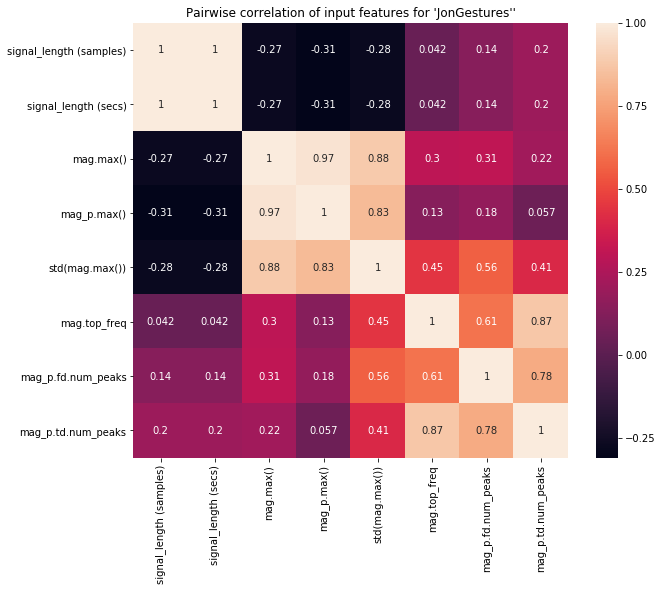

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features for '{selected_gesture_set.name}''")

We can also plot a "prettier" version of the correlation matrix (that also takes advantage of its symmetry by only showing one side).

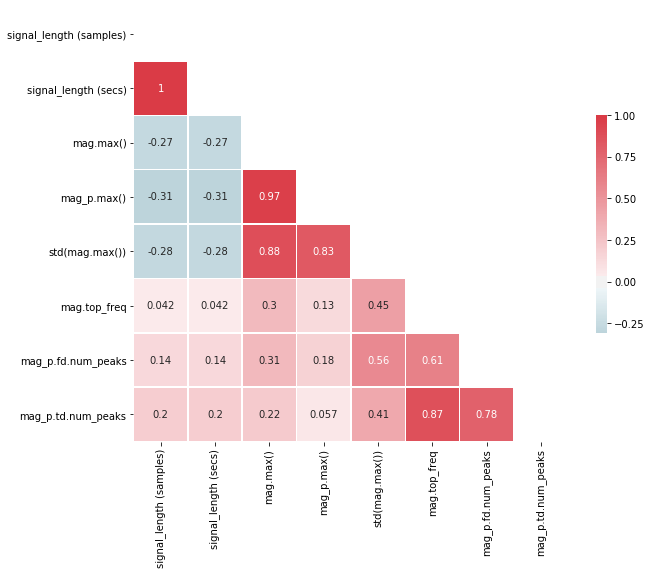

In [14]:
# Plot a "pretty" version of the correlation matrix 
# Based on: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Given that the correlation table is symmetrical, we remove one side 

# Generate a mask for the upper triangle
mask = np.zeros_like(pairwise_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pairwise_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

### Drop highly correlated features
We can use the results of the pairwise correlation to directly drop highly correlated features (see [link](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)).

In [15]:
# Create correlation matrix
# Take the abs value so both negative and positive correlations are mapped from 0 to 1
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

['signal_length (secs)', 'mag_p.max()']


In [16]:
# Drop features 
print(f"Dropping {len(to_drop)} features: {to_drop}")
filtered_df = df.drop(columns=to_drop)
print()
print("Remaining features:")
display(filtered_df.sample(5))

Dropping 2 features: ['signal_length (secs)', 'mag_p.max()']

Remaining features:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
3,889,8360.118659,73.913550,0.000000,0,0
10,287,50026.128213,8097.871597,1.282230,5,5
8,228,25896.547415,3643.390332,2.017544,4,3
50,300,36611.503329,6570.752364,1.226667,3,2
0,407,8392.926546,85.980464,0.000000,0,1


## Pair plots

A slightly different version of the pairwise correlation grids is a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html), which graphs a pairwise scattplot between each variable in a cell and a univariate distribution along the diagonal. Pairplots  combine our 2-dimensional explorations from before along with a pairwise correlation grid into a clean but highly information-dense visualization.

By default, just like the correlation grids above, the upper-right and lower-left (as split along the diagonal) are symmetrical. The diagonal shows a histrogram plot of the distribution of data for that variable. 

For more information, see:
- [Visualizing Data with Pair Plots](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166), Towards Data Science, April 2018
- [Section 1.7.3](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch01.html#first-things-first-look-at-your-data) of the [Introduction to Machine Learning with Python book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/), Andreas C. Müller & Sarah Guido, Oct 2016

C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


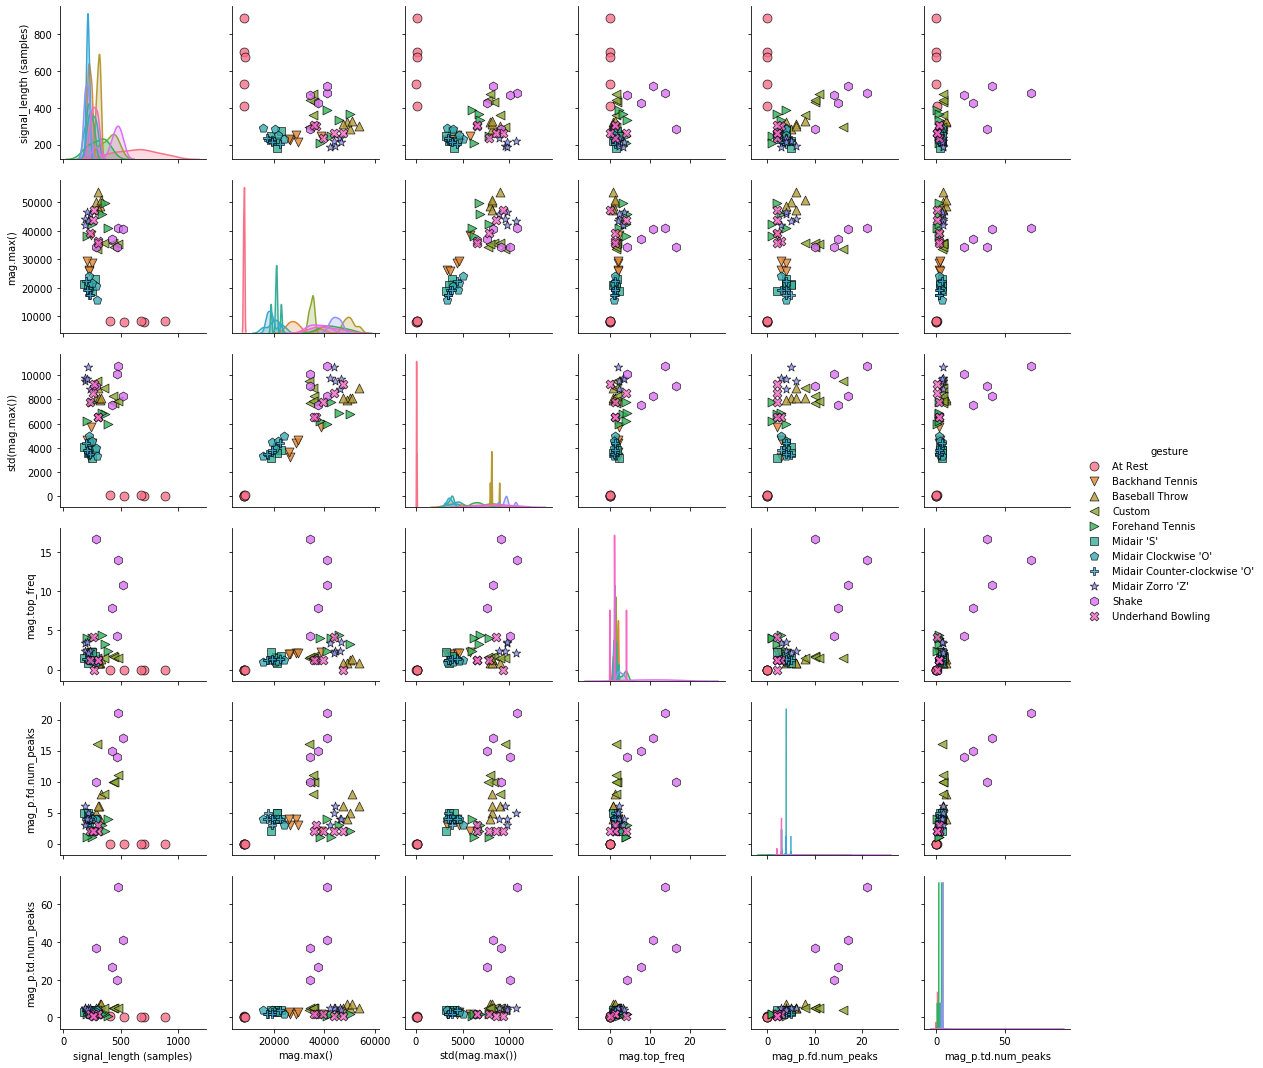

In [17]:
# Add the 'gesture' back into the DataFrame
pairplot_df = filtered_df.copy()
pairplot_df['gesture'] = df_gesture

# Create the pairplot (this might take a bit of time)
markers = grvis.plot_markers[:selected_gesture_set.get_num_gestures()]
sns.pairplot(pairplot_df, hue="gesture", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);

### Visualizing effect of StandardScaler

Let's visualize the effects of StandardScaler as we will have to normalize our data for certain feature selection algorithms (e.g., VarianceThreshold) and classifiers (e.g., SVMs).

In [18]:
from sklearn.preprocessing import StandardScaler

#cols_to_norm = ['Age','Height']
#surveyData[cols_to_norm] = StandardScaler().fit_transform(surveyData[cols_to_norm])
cols_to_normalize = filtered_df.columns.values

normalized_df_standard_scaler = filtered_df.copy()
normalized_df_standard_scaler[cols_to_normalize] = StandardScaler().fit_transform(filtered_df[cols_to_normalize])
display(filtered_df.head(5))
display(normalized_df_standard_scaler.head(5))


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
0,407,8392.926546,85.980464,0.0,0,1
1,702,8065.111035,63.786350,0.0,0,0
2,529,8032.764904,54.831833,0.0,0,0
3,889,8360.118659,73.913550,0.0,0,0
4,678,8489.624727,122.216694,0.0,0,0


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
0,0.627353,-1.826655,-2.023504,-0.806105,-1.140154,-0.462202
1,2.742211,-1.852236,-2.031070,-0.806105,-1.140154,-0.548669
2,1.501972,-1.854760,-2.034123,-0.806105,-1.140154,-0.548669
3,4.082815,-1.829215,-2.027618,-0.806105,-1.140154,-0.548669
4,2.570155,-1.819109,-2.011151,-0.806105,-1.140154,-0.548669


In [19]:
display(normalized_df_standard_scaler.describe())

,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
count,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01
mean,-4.541821e-17,9.891078e-17,3.350855e-16,-1.614870e-17,6.863197e-17,5.248327e-17
std,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00,1.009217e+00
min,-9.928424e-01,-1.854760e+00,-2.034123e+00,-8.061048e-01,-1.140154e+00,-5.486689e-01
25%,-6.774061e-01,-8.458854e-01,-7.379195e-01,-4.240122e-01,-5.802567e-01,-3.757360e-01
50%,-3.332937e-01,2.025569e-01,1.677877e-01,-3.043762e-01,-2.443186e-01,-2.892696e-01
75%,2.975790e-01,8.209800e-01,7.692242e-01,-4.220968e-02,9.161949e-02,-1.163367e-01
max,4.082815e+00,1.713765e+00,1.626484e+00,4.564696e+00,3.562980e+00,5.417516e+00


Now, let's visualize the normalized features. Compare the following pairplot to the one above. What do you see? To make the comparison easier, you could open this Notebook side-by-side in two tabs or copy one of the graphs as an image and open it in an image editor.

C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


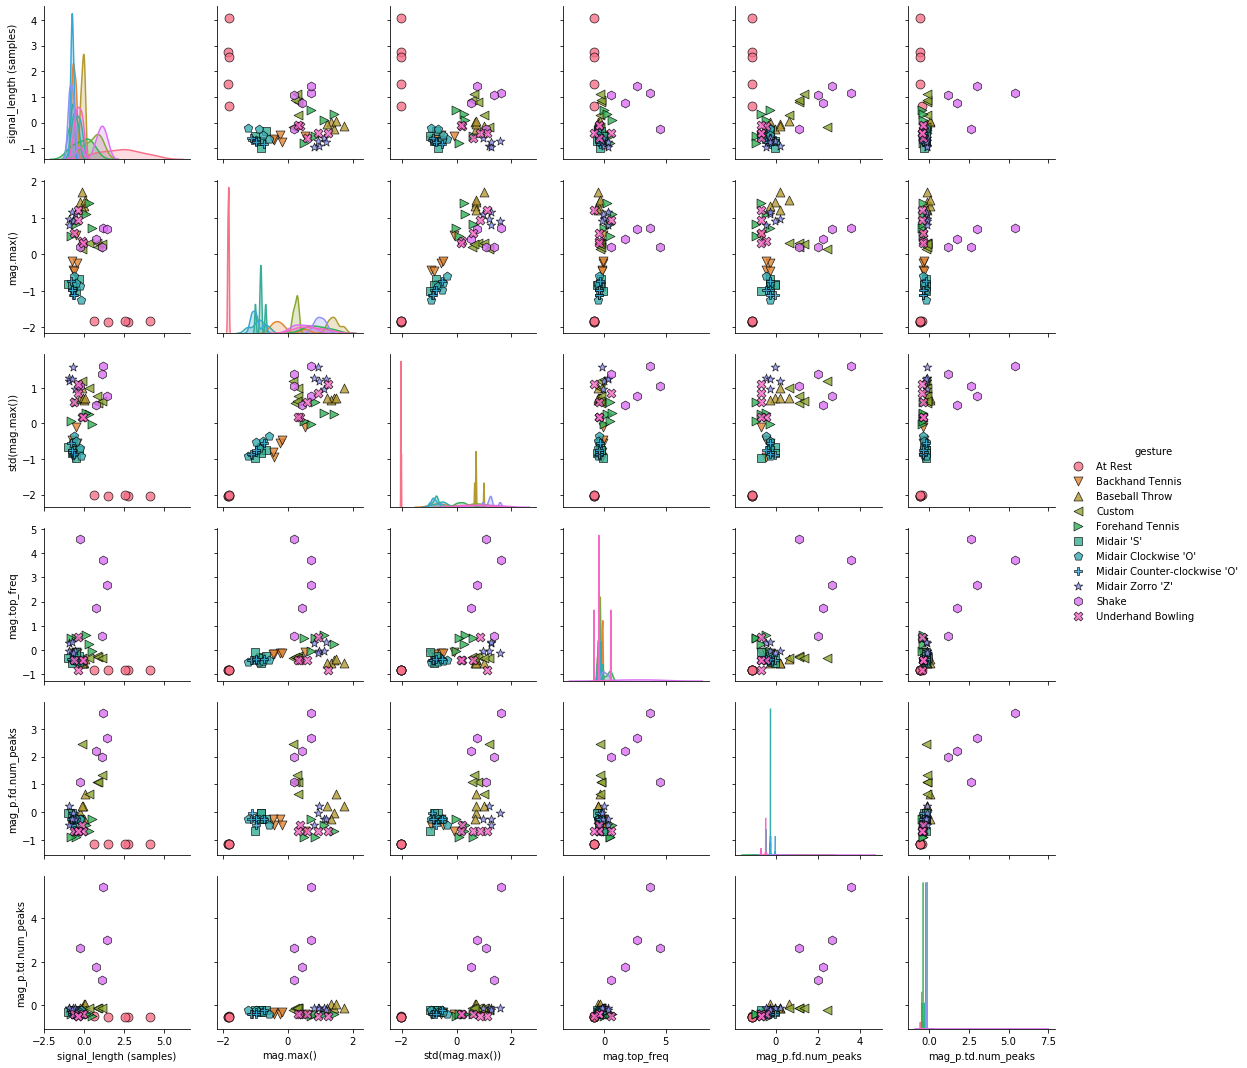

In [20]:
normalized_df_standard_scaler['gesture'] = df_gesture
sns.pairplot(normalized_df_standard_scaler, hue="gesture", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);

### Visualizing effect of MinMaxScaler

In [21]:
from sklearn.preprocessing import MinMaxScaler

cols_to_normalize = filtered_df.columns.values
normalized_df_minmax_scaler = filtered_df.copy()
normalized_df_minmax_scaler[cols_to_normalize] = MinMaxScaler().fit_transform(filtered_df[cols_to_normalize])
display(filtered_df.head(5))
display(normalized_df_standard_scaler.head(5))

,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
0,407,8392.926546,85.980464,0.0,0,1
1,702,8065.111035,63.786350,0.0,0,0
2,529,8032.764904,54.831833,0.0,0,0
3,889,8360.118659,73.913550,0.0,0,0
4,678,8489.624727,122.216694,0.0,0,0


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,gesture
0,0.627353,-1.826655,-2.023504,-0.806105,-1.140154,-0.462202,At Rest
1,2.742211,-1.852236,-2.031070,-0.806105,-1.140154,-0.548669,At Rest
2,1.501972,-1.854760,-2.034123,-0.806105,-1.140154,-0.548669,At Rest
3,4.082815,-1.829215,-2.027618,-0.806105,-1.140154,-0.548669,At Rest
4,2.570155,-1.819109,-2.011151,-0.806105,-1.140154,-0.548669,At Rest


C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jonfr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


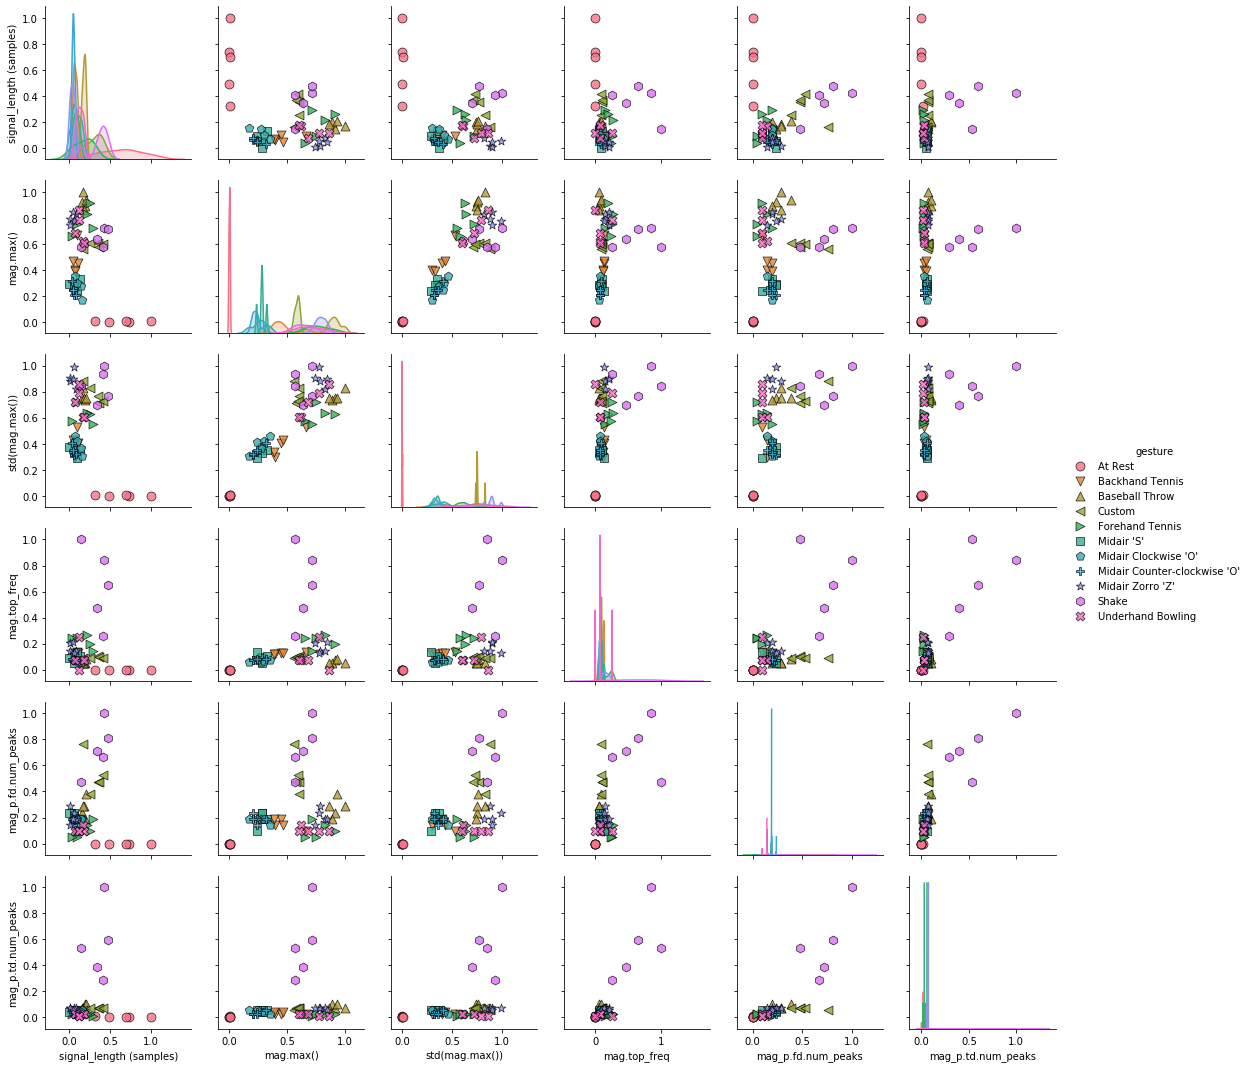

In [22]:
normalized_df_minmax_scaler['gesture'] = df_gesture
sns.pairplot(normalized_df_minmax_scaler, hue="gesture", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);

## Variance threshold

Both [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) and [variance](https://en.wikipedia.org/wiki/Variance) measure the amount of variation in a set of values. Standard deviation is often more intuitive because it is expressed in the same units as the mean while variance is expressed in square units. More precisely, variance is the average of the squared differences from the mean (and standard deviation is just the square root of the variance).

$var = \frac{1}{N}\sum_{i=1}^n (x_i - \bar{x})$

$std = \sqrt{var}$

If a feature does not vary much between classes—in this case, gesture types—it is not going to be particularly informative to our classification model. For example, if an input feature is always `15` regardless of gesture, then the feature is meaningless. More formally, it's variance is `0`, and we can remove it.

Scikit-learn has a built-in feature "selector" or "filter" for this called [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), which removes all features with a variance lower than a provided threshold. By default, this threshold is `0`—that is, features that have the same value in all samples are removed. 

Because variance is range dependent, normalization should be applied before using this technique ([StackOverflow](https://stats.stackexchange.com/questions/253920/should-we-normalize-before-using-variancethreshold-in-sklearn)).

Let's try it!

### Build new dataset
Let's start over with a new DataFrame with our input features and ground truth labels.

In [23]:
# Build our DataFrame of input features and ground truth labels
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
(feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
df = pd.DataFrame(feature_vectors, columns = feature_names)

# Drop the features like 'trial_num' 'gesturer' that are not actually input features
df_trial_indices = df.pop('trial_num')
df_gesturer = df.pop('gesturer')
df_gesture = df.pop('gesture') # ground truth labels

# Filter out highly correlated features
filtered_df = filter_correlated_features(df, 0.95)
print(f"Total features remaining: {len(filtered_df.columns)}")
display(filtered_df.sample(8))

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 6


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
25,222,20797.495234,3856.135414,1.657658,4,4
10,287,50026.128213,8097.871597,1.282230,5,5
52,233,39258.623919,7791.970944,1.184549,2,2
7,254,28739.692413,4382.955449,2.173228,4,2
42,220,43618.174561,10698.269643,2.090909,5,5
3,889,8360.118659,73.913550,0.000000,0,0
45,481,41013.277850,10792.644554,13.962578,21,69
33,223,19283.126717,4475.736713,1.237668,4,4


### Explore feature variance
Let's look at the variance of the remaining features.

In [24]:
filtered_df.var()

signal_length (samples)    1.981759e+04
mag.max()                  1.672590e+08
std(mag.max())             8.763836e+06
mag.top_freq               9.705860e+00
mag_p.fd.num_peaks         2.030640e+01
mag_p.td.num_peaks         1.362303e+02
dtype: float64

Or perhaps it's easier to look at them in as HTML-formatted table.

In [25]:
display(pd.DataFrame(filtered_df.var(), columns=["Variance"]).T)

,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
Variance,19817.587879,1.672590e+08,8.763836e+06,9.70586,20.306397,136.230303


### Normalize features

By default, [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) filters out all features with a variance of `0`—that is, they don't vary **at all** across samples. This is clearly not the case with our features. The `signal_length (samples)` variance, for example, is `19817.6`. The least varying variable appears to be `mag.top_freq`—however, we have to be careful with drawing inferences here because each of these features have different ranges!

So, as noted above, we need to apply normalization first before applying the [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) filter.

In [26]:
normalized_data = MinMaxScaler().fit_transform(filtered_df)
normalized_df = pd.DataFrame(normalized_data, columns = filtered_df.columns)
display(pd.DataFrame(normalized_df.var(), columns=["Variance"]).T)

,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
Variance,0.039535,0.079982,0.076009,0.035309,0.046046,0.028614


### Applying VarianceThreshold

Let's apply `VarianceThreshold` with a threshold of 0.03. Given the variance table above, only `mag_p.td.num_peaks` should be eliminated. And remember, typically, we would only do this on a training set. Here, we are applying it to our full dataset for illustrative purposes. Later, we'll show a full end-to-end example.

In [52]:
from sklearn.feature_selection import VarianceThreshold
feature_selector = VarianceThreshold(0.03)
filtered_data = feature_selector.fit_transform(normalized_df)
mask = feature_selector.get_support()

print(f"Feature elimination mask: {mask}") # Columns that are False were eliminated
print(f"Num of eliminated features: {len(np.where(mask == False)[0])}")
print(f"The eliminated features: {normalized_df.columns[~mask]}")

Feature elimination mask: [ True  True  True  True  True False]
Num of eliminated features: 1
The eliminated features: Index(['mag_p.td.num_peaks'], dtype='object')


As expected, `mag_p.td.num_peaks` was eliminated. It's sometimes helpful to visualize the feature elimination mask, which we do below. Here, black means feature eliminated while white means feature included.

Feature indices to eliminate: (array([5], dtype=int64),)
The eliminated features: Index(['mag_p.td.num_peaks'], dtype='object')


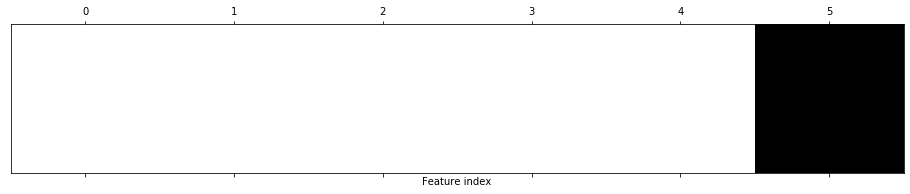

In [53]:
# visualize the mask: black means feature was eliminated
print(f"Feature indices to eliminate: {np.where(mask == False)}")
print(f"The eliminated features: {normalized_df.columns[~mask]}")
plt.matshow(~mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Feature index")
plt.yticks(());

We can also turn the remaining data back into a DataFrame (which simply makes it easier to visualize).

In [54]:
remaining_df = pd.DataFrame(filtered_data, columns = normalized_df.columns[mask])
display(remaining_df.head())

,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks
0,0.319209,0.007876,0.002901,0.0,0.0
1,0.735876,0.000707,0.000834,0.0,0.0
2,0.491525,0.000000,0.000000,0.0,0.0
3,1.000000,0.007158,0.001777,0.0,0.0
4,0.701977,0.009990,0.006275,0.0,0.0


### Full end-to-end classification example

Let's show a full end-to-end classification example with a `VarianceThreshold` of `0.03`. This is purely for illustrative purposes. We are not recommending using a `MinMaxScaler` transform with a `VarianceThreshold` of `0.03` for actual gesture classification.

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 6
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264


Feature elimination mask: [ True  True  True  True  True False]
Num of eliminated features: 1
The eliminated features: Index(['mag_p.td.num_peaks'], dtype='object')
Feature indices to eliminate (in black below): (array([5], dtype=int64),)


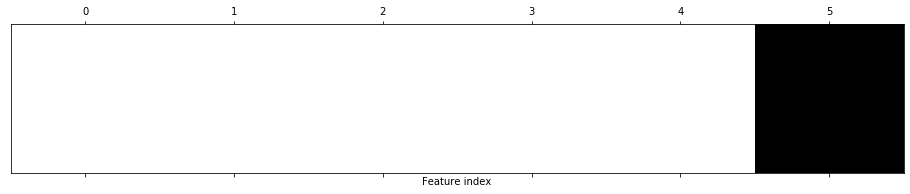

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.fd.num_peaks'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.727
Scaled and filtered accuracy: 0.727


In [57]:
# Build our DataFrame of input features and ground truth labels
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
(feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
df = pd.DataFrame(feature_vectors, columns = feature_names)

# Drop the features like 'trial_num' 'gesturer' that are not actually input features
df_trial_indices = df.pop('trial_num')
df_gesturer = df.pop('gesturer')
df_gesture = df.pop('gesture') # ground truth labels

# Filter out highly correlated features
filtered_df = filter_correlated_features(df, 0.95)
print(f"Total features remaining: {len(filtered_df.columns)}")

# Setup an 80/20 split for training and testing stratified around gesture type
X = filtered_df # input features
y = df_gesture # ground truth labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 3)

# Create machine learning model
clf = svm.SVC(kernel='linear', C=1)

# Train the model and compute a baseline classification score
clf.fit(X_train, y_train)
baseline_score = clf.score(X_test, y_test)

# Now scale data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute scaled data score
clf.fit(X_train_scaled, y_train) # retrain model
scaled_data_score = clf.score(X_test_scaled, y_test)

print("Before scaling variance:")
display(pd.DataFrame(X_train.var(), columns=["Variance"]).T)

print("After scaling variance:")
scaled_df = pd.DataFrame(X_train_scaled, columns = filtered_df.columns)
display(pd.DataFrame(scaled_df.var(), columns=["Variance"]).T)

# Apply variance threshold
feature_selector = VarianceThreshold(0.035) 
feature_selector.fit(X_train_scaled, y_train)
X_train_selected = feature_selector.transform(X_train_scaled)
X_test_selected = feature_selector.transform(X_test_scaled)

# Visualize filtered features
feature_selector_mask = feature_selector.get_support()
print(f"Feature elimination mask: {feature_selector_mask}") # Columns that are False were eliminated
print(f"Num of eliminated features: {len(np.where(feature_selector_mask == False)[0])}")
print(f"The eliminated features: {scaled_df.columns[~feature_selector_mask]}")
print(f"Feature indices to eliminate (in black below): {np.where(feature_selector_mask == False)}")
plt.matshow(~feature_selector_mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Feature index")
plt.yticks(())
plt.show()
print(f"The final set of input features: {scaled_df.columns[feature_selector_mask]}")

# Compute final score (with filtered, scaled data)
clf.fit(X_train_selected, y_train) # retrain model
scaled_and_filtered_score = clf.score(X_test_selected, y_test)

print("---")
print(f"Baseline accuracy: {baseline_score:.3f}")
print(f"Scaled accuracy: {scaled_data_score:.3f}")
print(f"Scaled and filtered accuracy: {scaled_and_filtered_score:.3f}")

### Adding dummy variables for experimentation
We can also add in some dummy features, some of which will be easier to detect such as the constant variables `dummy_always15`, which is always `15`, and `dummy_always999`, which is always `999`. And some of which will be harder for a `VarianceThreshold` approach to identify and filter, such as random gaussian distributions with a standard deviation of approximately `0.1` (feature name: `dummy_normaldist_stddev0.1`) and `3` (`dummy_normaldist_stddev3`).

We've also built a utility function called `classify_df` that does the exact same thing as the cell above (but just enables us to more cleanly run this code over and over, so we wrapped it in a function).

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True  True  True  True False False False  True  True]
Num of eliminated features: 3
The eliminated features: Index(['mag_p.td.num_peaks', 'dummy_always15', 'dummy_always999'], dtype='object')
Feature indices to eliminate (in black below): (array([5, 6, 7], dtype=int64),)


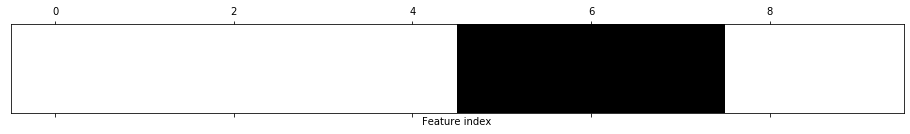

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.fd.num_peaks', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.545


In [58]:
# Build our DataFrame of input features and ground truth labels
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
(feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
df = pd.DataFrame(feature_vectors, columns = feature_names)

# Add in dummy variables
np.random.seed(20) # set the seed for consistency across executions
df['dummy_always15'] = np.full(len(df), 15)
df['dummy_always999'] = np.full(len(df), 999)
df['dummy_normaldist_stddev0.1'] = np.random.normal(0, 0.1, len(df))
df['dummy_normaldist_stddev3'] = np.random.normal(0, 3, len(df))

classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), VarianceThreshold(0.035), random_state = 3)


You'll note that while the `VarianceThreshold` approach was able to detect and eliminate `dummy_always15` and `dummy_always999`, this was (likely) not the case for the "harder to detect" dummy features. (I say likely here because it depends on the random data).

Let's look at some more sophisticated approaches.

## Univariate feature selection

A second feature selection approach uses univariate statistical tests. As Müller and Guido describe, "[with] univariate statistics, we compute whether there is a statistically significant relationship between each feature and the target. Then the features that are related with the highest confidence are selected. In the case of classification, this is also known as *analysis of variance* (ANOVA). A key property of these tests is that they are univariate, meaning that they only consider each feature individually. Consequently, a feature will be discarded if it is only informative when combined with another feature. Univariate tests are often very fast to compute, and don’t require building a model. On the other hand, they are completely independent of the model that you might want to apply after the feature selection" ([Section 4.7.1](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/)).

Fortunately, once again, Scikit-learn [has us covered](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) with methods like [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest), which removes all but the $k$ highest scoring features and [`SelectPercentile`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile), which removes all but the highest scoring percentages of all features. We'll highlight just one technique below: [`SelectPercentile`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile).

Note that these methods are **supervised methods** meaning that they need the target (ground truth) labels for fitting a model, which also means that to use these methods, we need to split our data into training and test sets and learn a feature selection model based only on the training set.



### SelectPercentile

[`SelectPercentile`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) selects the top N% performing features based on a univariate test (defaults to ANOVA).

Let's start by eliminating `20%`of our input features (we have 10 input features after pairwise correlation elimination, so 20% will result in removing 2 features).

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True  True  True  True  True False False  True  True]
Num of eliminated features: 2
The eliminated features: Index(['dummy_always15', 'dummy_always999'], dtype='object')
Feature indices to eliminate (in black below): (array([6, 7], dtype=int64),)


C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [6 7] are constant.
  UserWarning)
C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


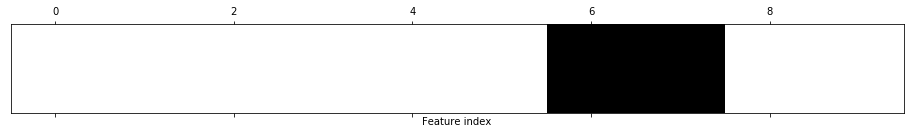

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.fd.num_peaks', 'mag_p.td.num_peaks',
       'dummy_normaldist_stddev0.1', 'dummy_normaldist_stddev3'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.545


In [59]:
from sklearn.feature_selection import SelectPercentile

classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), SelectPercentile(percentile=80), random_state = 3)

How about removing `40%` of features? This would correspond to our four dummy variables... can we detect them?

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True  True  True  True  True False False False False]
Num of eliminated features: 4
The eliminated features: Index(['dummy_always15', 'dummy_always999', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([6, 7, 8, 9], dtype=int64),)


C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [6 7] are constant.
  UserWarning)
C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


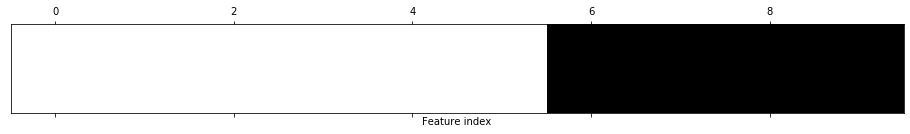

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.fd.num_peaks', 'mag_p.td.num_peaks'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.727


In [60]:
classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), SelectPercentile(percentile=60), random_state = 3)

### SelectKBest
[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) is the same as `SelectPercentile` but here you define the top $k$ features to select rather than a percentage. Let's try it with $k=4$.

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True  True  True  True  True False False False False]
Num of eliminated features: 4
The eliminated features: Index(['dummy_always15', 'dummy_always999', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([6, 7, 8, 9], dtype=int64),)


C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [6 7] are constant.
  UserWarning)
C:\Users\jonfr\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


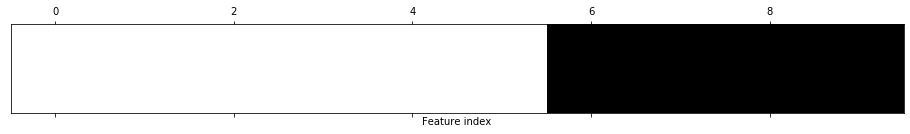

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.fd.num_peaks', 'mag_p.td.num_peaks'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.727


In [61]:
from sklearn.feature_selection import SelectKBest

classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), SelectKBest(k=6), random_state = 3)

## Recursive feature elimination (RFE)
[Recursive feature elimination (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) selects features by recursively considering smaller and smaller sets of features ([link](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination)). First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFE takes, as input, three key parameters:
- **estimator**: an estimator (or classifier) that provides information about feature importance either through a coef_ attribute or through a feature_importances_ attribute. This supervised model can be totally different than the one you use for classification.
- **n_features_to_select**: the number of features to keep. If None, defaults to half of the features.
- **step**: the number of features to step down by in each iteration. By default, is 1. If within (0.0, 1.0), then step corresponds to the percentage (rounded down) of features to remove at each iteration

See also [Section 4.7.3](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch04.html) of [Müller &  Guido, Oct 2016](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880).

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True  True  True False  True False False False False]
Num of eliminated features: 5
The eliminated features: Index(['mag_p.fd.num_peaks', 'dummy_always15', 'dummy_always999',
       'dummy_normaldist_stddev0.1', 'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([4, 6, 7, 8, 9], dtype=int64),)


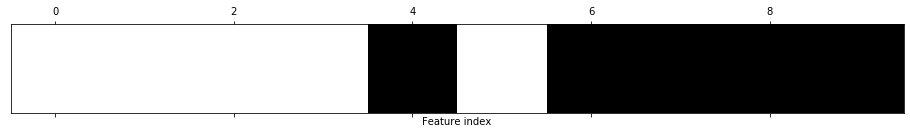

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'std(mag.max())',
       'mag.top_freq', 'mag_p.td.num_peaks'],
      dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.636


In [62]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# n_features_to_select is the number of features to select. If None, selects top 50% performing features
feature_selector = RFE(DecisionTreeClassifier(random_state = 0), n_features_to_select=5)
classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), feature_selector, random_state = 3)

How about if we only keep **three** features:

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [ True  True False False False  True False False False False]
Num of eliminated features: 7
The eliminated features: Index(['std(mag.max())', 'mag.top_freq', 'mag_p.fd.num_peaks',
       'dummy_always15', 'dummy_always999', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([2, 3, 4, 6, 7, 8, 9], dtype=int64),)


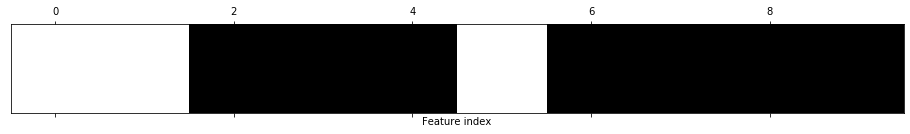

The final set of input features: Index(['signal_length (samples)', 'mag.max()', 'mag_p.td.num_peaks'], dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.545


In [63]:
feature_selector = RFE(DecisionTreeClassifier(random_state = 0), n_features_to_select=3)
classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), feature_selector, random_state = 3)

### Using a RandomForestClassifier

Let's use a different model for RFE, how about a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), which trains a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. This will be more computationally expensive but should lead to a better result.

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [False  True  True  True False False False False False False]
Num of eliminated features: 7
The eliminated features: Index(['signal_length (samples)', 'mag_p.fd.num_peaks', 'mag_p.td.num_peaks',
       'dummy_always15', 'dummy_always999', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([0, 4, 5, 6, 7, 8, 9], dtype=int64),)


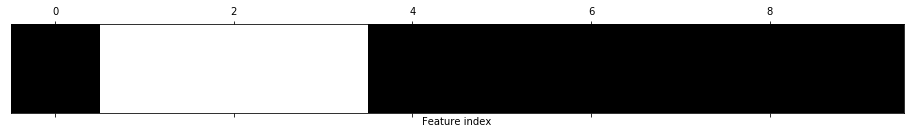

The final set of input features: Index(['mag.max()', 'std(mag.max())', 'mag.top_freq'], dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.636


In [64]:
feature_selector = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=3)
classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), feature_selector, random_state = 3)

How about if we select just one feature, which feature will be selected and what will the result be?

Dropping ['signal_length (secs)', 'mag_p.max()']
Total features remaining: 10
Before scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,21614.069239,1.707987e+08,8.923390e+06,11.686024,21.48203,163.128964,0.0,0.0,0.013025,9.907599


After scaling variance:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks,dummy_always15,dummy_always999,dummy_normaldist_stddev0.1,dummy_normaldist_stddev3
Variance,0.043119,0.093487,0.077522,0.042513,0.048712,0.034264,0.0,0.0,0.047264,0.066898


Feature elimination mask: [False  True False False False False False False False False]
Num of eliminated features: 9
The eliminated features: Index(['signal_length (samples)', 'std(mag.max())', 'mag.top_freq',
       'mag_p.fd.num_peaks', 'mag_p.td.num_peaks', 'dummy_always15',
       'dummy_always999', 'dummy_normaldist_stddev0.1',
       'dummy_normaldist_stddev3'],
      dtype='object')
Feature indices to eliminate (in black below): (array([0, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)


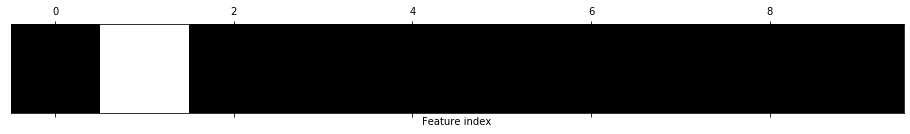

The final set of input features: Index(['mag.max()'], dtype='object')
---
Baseline accuracy: 0.636
Scaled accuracy: 0.545
Scaled and filtered accuracy: 0.545


In [65]:
feature_selector = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=1)
classify_df(df, svm.SVC(kernel='linear', C=1), MinMaxScaler(), feature_selector, random_state = 3)

# Hyperparameter Tuning

Hyperparameters—a term that I love (feels very [Spaceballian](https://en.wikipedia.org/wiki/Spaceballs))—are the parameters passed as arguments to a classification model. For example, with the [k-Nearest Neighbor (kNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) algorithm, you can set the number of neighbors $k$ and the distance metric/similarity function; for a [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/svm.html), you can set the `C`, `kernel`, and `gamma` hyperparameters, for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), the `alpha` hyperparameter.

Hyperparameter tuning is typically the very last step in optimizing your full classification workflow. 

## Danger of overfitting parameters

To do hyperparameter tuning appropriately, we really need to split up our data into three parts.

- Parts 1 and 2 would be the typical cross-validation training and test sets, which we could also use for hyperparameter tuning
- Part 3 would be a final validation test set that we never touch until the very end and apply our trained and tuned model.

![Image of three-part split](https://raw.githubusercontent.com/makeabilitylab/physcomp/master/signals/assets/images/3PartSplit_TrainingValidationTest_MullerGuidoTextbookFigure5.5.png)

Why? Because we are learning these parameters using the test data.

We don't have enough data for this workflow, so we will continue to just split up our data into a cross-validation training and test set.

## Manual hyperparameter grid search

As Müller and Guido explain, "Finding the values of the important parameters of a model (the ones that provide the best generalization performance) is a tricky task, but necessary for almost all models and datasets. Because it is such a common task, there are standard methods in Scikit-learn to help you with it. The most commonly used method is grid search, which basically means trying all possible combinations of the parameters of interest" ([Section 5.2](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch05.html)).

First, let's implement  a manual grid search (based on [Section 5.2.1](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch05.html) in the Müller and Guido book).

In [66]:
# Build our DataFrame of input features and ground truth labels
selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, "Jon")
(feature_vectors, feature_names) = extract_features_from_gesture_set(selected_gesture_set)
df = pd.DataFrame(feature_vectors, columns = feature_names)

# Drop the features like 'trial_num' 'gesturer' that are not actually input features
df_trial_indices = df.pop('trial_num')
df_gesturer = df.pop('gesturer')
df_gesture = df.pop('gesture') # ground truth labels

# Setup an 80/20 split for training and testing stratified around gesture type
X = filtered_df # input features
y = df_gesture # ground truth labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 3)

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        clf = svm.SVC(gamma=gamma, C=C)
        clf.fit(X_train, y_train)
        
        # evaluate the SVC on the test set
        score = clf.score(X_test, y_test)
        
        print(f"Gamma={gamma} C={C} | Accuracy: {score}")
        
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("-----")
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Gamma=0.001 C=0.001 | Accuracy: 0.36363636363636365
Gamma=0.001 C=0.01 | Accuracy: 0.36363636363636365
Gamma=0.001 C=0.1 | Accuracy: 0.36363636363636365
Gamma=0.001 C=1 | Accuracy: 0.36363636363636365
Gamma=0.001 C=10 | Accuracy: 0.36363636363636365
Gamma=0.001 C=100 | Accuracy: 0.36363636363636365
Gamma=0.01 C=0.001 | Accuracy: 0.2727272727272727
Gamma=0.01 C=0.01 | Accuracy: 0.2727272727272727
Gamma=0.01 C=0.1 | Accuracy: 0.2727272727272727
Gamma=0.01 C=1 | Accuracy: 0.2727272727272727
Gamma=0.01 C=10 | Accuracy: 0.2727272727272727
Gamma=0.01 C=100 | Accuracy: 0.2727272727272727
Gamma=0.1 C=0.001 | Accuracy: 0.09090909090909091
Gamma=0.1 C=0.01 | Accuracy: 0.09090909090909091
Gamma=0.1 C=0.1 | Accuracy: 0.09090909090909091
Gamma=0.1 C=1 | Accuracy: 0.09090909090909091
Gamma=0.1 C=10 | Accuracy: 0.09090909090909091
Gamma=0.1 C=100 | Accuracy: 0.09090909090909091
Gamma=1 C=0.001 | Accuracy: 0.09090909090909091
Gamma=1 C=0.01 | Accuracy: 0.09090909090909091
Gamma=1 C=0.1 | Accuracy: 0.0

## GridSearchCV

Now, let's use the Scikit-learn version. The official Scikit-learn documentation states that [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) performs an "exhaustive search over specified parameter values for a classifier." We are going to use Stratified K-fold cross validation rather than a simple 80/20 test split.

In [40]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'degree': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly']},
 ]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) 
clf = svm.SVC() # passing parameters here won't matter, since grid search does it for us

grid_search = GridSearchCV(clf, param_grid, cv=skf, return_train_score=True)
grid_search.fit(X, y)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.65
Best estimator:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Display grid search results in a DataFrame

We can grab the entirety of the grid search results, which are stored as a dictionary in `grid_search.cv_results_` and throw them into a DataFrame for easy viewing and manipulation.

Let's show the top 10 results sorted by `mean_test_score` then `std_test_score`.

In [41]:
grid_search_results_df = pd.DataFrame(grid_search.cv_results_)
sorted_grid_df = grid_search_results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)
display(sorted_grid_df.head(n=10))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,param_degree,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.015804,5.115295e-03,0.001996,0.000628,1,linear,NaN,NaN,"{'C': 1, 'kernel': 'linear'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.013804,6.668922e-03,0.001597,0.000486,10,linear,NaN,NaN,"{'C': 10, 'kernel': 'linear'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.011413,4.993067e-03,0.001024,0.000026,100,linear,NaN,NaN,"{'C': 100, 'kernel': 'linear'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.010797,4.491257e-03,0.000590,0.000482,1000,linear,NaN,NaN,"{'C': 1000, 'kernel': 'linear'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
20,0.010005,3.747664e-03,0.001000,0.000023,NaN,poly,0.1,1,"{'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
21,0.009596,3.004781e-03,0.000797,0.000399,NaN,poly,0.01,1,"{'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}",0.636364,...,0.654545,0.036364,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
22,0.012593,1.421071e-02,0.000998,0.000023,NaN,poly,0.001,1,"{'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}",0.636364,...,0.654545,0.036364,1,0.977273,0.954545,0.977273,1.000000,1.000000,0.981818,0.017008
23,0.002417,4.622591e-04,0.000593,0.000485,NaN,poly,0.0001,1,"{'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}",0.636364,...,0.600000,0.072727,8,0.931818,0.931818,0.909091,0.931818,0.931818,0.927273,0.009091
7,0.003002,1.549482e-03,0.001198,0.000400,1,rbf,0.0001,NaN,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.363636,...,0.400000,0.168611,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
11,0.002000,4.909339e-07,0.001200,0.000400,10,rbf,0.0001,NaN,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.363636,...,0.400000,0.168611,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


Let's print out the same table but just the columns of key interest for us at the moment.

In [42]:
cols_of_interest = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
display(sorted_grid_df[cols_of_interest].head(n=10))

,params,mean_test_score,std_test_score,rank_test_score
0,"{'C': 1, 'kernel': 'linear'}",0.654545,0.036364,1
1,"{'C': 10, 'kernel': 'linear'}",0.654545,0.036364,1
2,"{'C': 100, 'kernel': 'linear'}",0.654545,0.036364,1
3,"{'C': 1000, 'kernel': 'linear'}",0.654545,0.036364,1
20,"{'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}",0.654545,0.036364,1
21,"{'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}",0.654545,0.036364,1
22,"{'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}",0.654545,0.036364,1
23,"{'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}",0.600000,0.072727,8
7,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.400000,0.168611,9
11,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.400000,0.168611,9


### Line graph of grid search results

Let's plot a line graph of the grid search results sorted by `mean_test_score`.

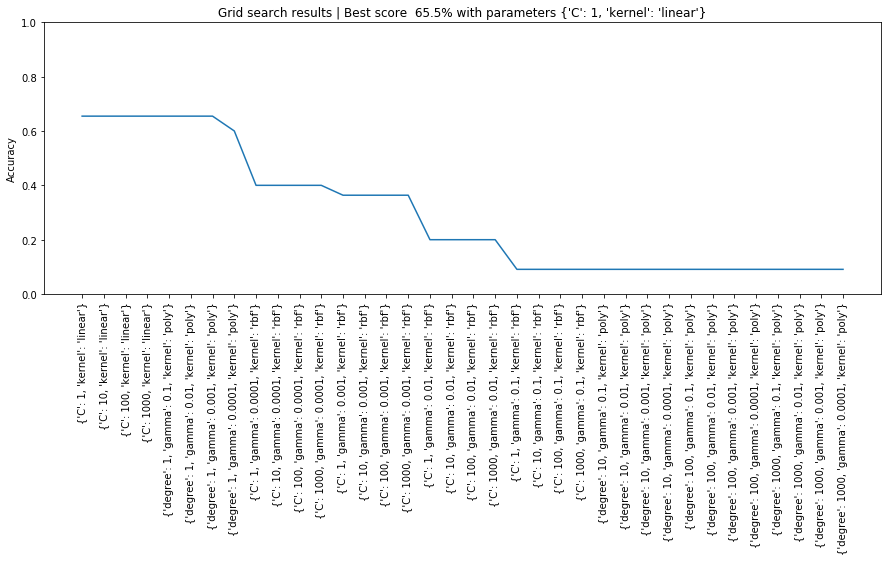

In [43]:
# plot of grid search
x = np.arange(0, len(sorted_grid_df), 1)
plt.figure(figsize=(15, 5))
plt.plot(x, sorted_grid_df['mean_test_score'])
plt.xticks(x, sorted_grid_df['params'], rotation='vertical')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title(f"Grid search results | Best score {grid_search.best_score_ * 100: 0.1f}% with parameters {grid_search.best_params_}")
plt.show()

### Heatmap of grid search

We can also create other visualizations of the results, which help us understand the relationship between hyperparameters and performance

Text(0.5, 1, 'Poly kernel grid search results')

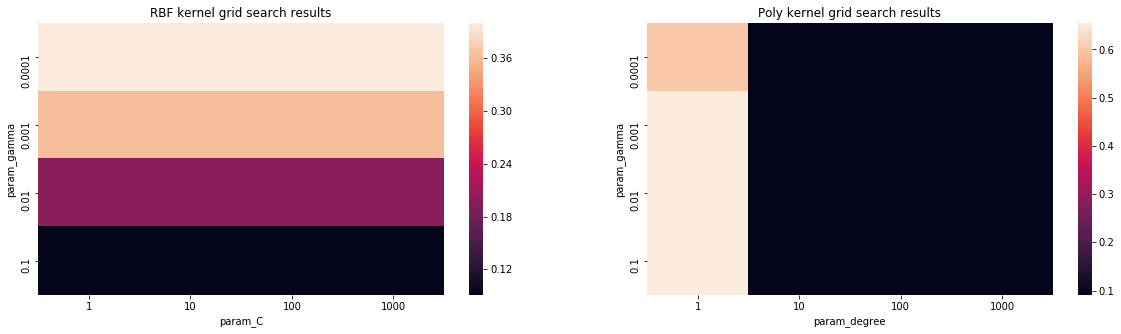

In [44]:
grid_search_results_df_kernel = grid_search_results_df[grid_search_results_df.param_kernel == 'rbf']
results_df_rbf = grid_search_results_df_kernel[['mean_test_score', 'param_C', 'param_gamma']]
#display(results_df_rbf)
pivot_rbf = pd.pivot_table(results_df_rbf, values='mean_test_score', columns='param_C', index='param_gamma')

grid_search_results_df_kernel = grid_search_results_df[grid_search_results_df.param_kernel == 'poly']
results_df_poly = grid_search_results_df_kernel[['mean_test_score', 'param_degree', 'param_gamma']]
#display(results_df_rbf)
pivot_poly = pd.pivot_table(results_df_poly, values='mean_test_score', columns='param_degree', index='param_gamma')

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(pivot_rbf, ax=axes[0])
sns.heatmap(pivot_poly, ax=axes[1])
axes[0].set_title("RBF kernel grid search results")
axes[1].set_title("Poly kernel grid search results")
#plt.title(gesture_set.name)
#plt.show()

### Running GridSearchCV with a pipeline object

Clearly, grid search is a really powerful experimental framework to allow us to evaluate the efficacy of different hyperparameters; however, we only tested a *raw* classifier above. Recall that we actually have a full pipeline of scaling data, feature selection, etc.

#### Running with scaling

In [45]:
# Setup pipeline object
pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', svm.SVC())]) 

# Setup our hyperparameter ranges for the grid search. 
C_range = np.logspace(-2, 10, 13) # old: [1, 10, 100, 1000, 5000, 10000]
gamma_range = np.logspace(-9, 3, 13) # old: [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    
# The hierarchy in the pipeline can be reached using double underscore(‘__’)
param_grid = [
  {'estimator__degree': [1, 2, 3, 4], 'estimator__gamma': gamma_range, 'estimator__kernel': ['poly']},  
  {'estimator__C': C_range, 'estimator__kernel': ['linear']},
  {'estimator__C': C_range, 'estimator__gamma': gamma_range, 'estimator__kernel': ['rbf']},
 ]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) 

grid_search = GridSearchCV(pipeline, param_grid, cv=skf, return_train_score=True)
grid_search.fit(X, y)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best parameters: {'estimator__degree': 1, 'estimator__gamma': 10.0, 'estimator__kernel': 'poly'}
Best cross-validation score: 0.82
Best estimator:
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=1, gamma=10.0,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


Let's dive into the results a bit more. First, show a table of the top 10 results, which helps us see the drop off in performance and which params were most effective.

In [46]:
grid_search_results_df = pd.DataFrame(grid_search.cv_results_)
sorted_grid_df = grid_search_results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)
cols_of_interest = ['params', 'param_estimator__kernel', 'mean_test_score', 'std_test_score', 'rank_test_score']
display(sorted_grid_df[cols_of_interest].head(n=10))

,params,param_estimator__kernel,mean_test_score,std_test_score,rank_test_score
10,"{'estimator__degree': 1, 'estimator__gamma': 1...",poly,0.818182,0.057496,1
55,"{'estimator__C': 10.0, 'estimator__kernel': 'l...",linear,0.818182,0.057496,1
11,"{'estimator__degree': 1, 'estimator__gamma': 1...",poly,0.800000,0.068030,3
12,"{'estimator__degree': 1, 'estimator__gamma': 1...",poly,0.800000,0.068030,3
56,"{'estimator__C': 100.0, 'estimator__kernel': '...",linear,0.800000,0.068030,3
57,"{'estimator__C': 1000.0, 'estimator__kernel': ...",linear,0.800000,0.068030,3
58,"{'estimator__C': 10000.0, 'estimator__kernel':...",linear,0.800000,0.068030,3
59,"{'estimator__C': 100000.0, 'estimator__kernel'...",linear,0.800000,0.068030,3
60,"{'estimator__C': 1000000.0, 'estimator__kernel...",linear,0.800000,0.068030,3
61,"{'estimator__C': 10000000.0, 'estimator__kerne...",linear,0.800000,0.068030,3


And let's graph this data just as we did before:

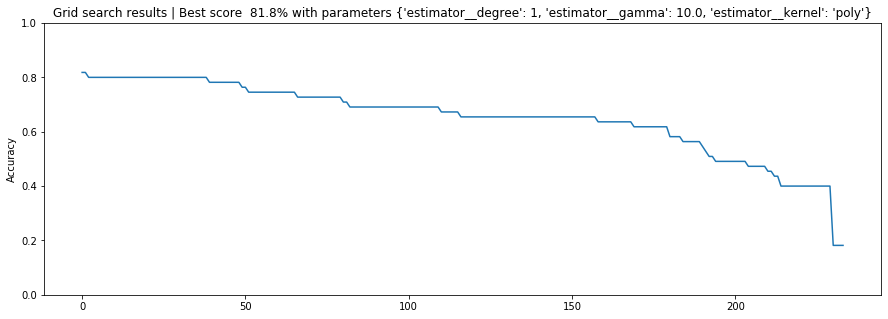

In [47]:
# plot of grid search
x = np.arange(0, len(sorted_grid_df), 1)
plt.figure(figsize=(15, 5))
plt.plot(x, sorted_grid_df['mean_test_score'])

# Can't really change the x-ticks here. Too many params
# plt.xticks(x, sorted_grid_df['params'], rotation='vertical')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title(f"Grid search results | Best score {grid_search.best_score_ * 100: 0.1f}% with parameters {grid_search.best_params_}")
plt.show()

Poly and linear kernels seemed to perform best. Let's make a heatmap of the poly grid search

Text(0.5, 1, 'Grid Search Results for SVM Poly Kernel')

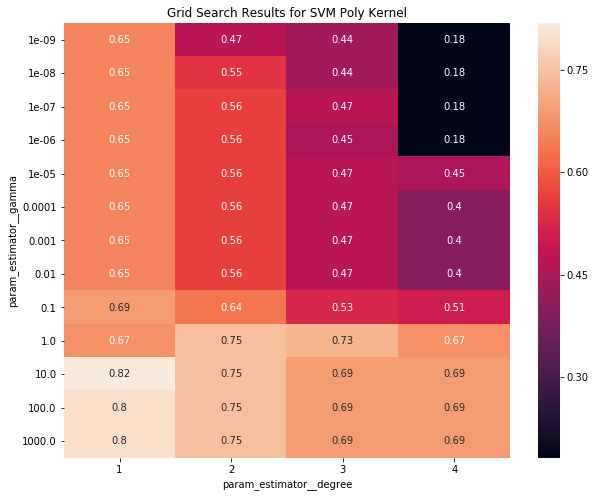

In [48]:
grid_search_results_df_kernel = grid_search_results_df[grid_search_results_df.param_estimator__kernel == 'poly']
results_df_poly = grid_search_results_df_kernel[['mean_test_score', 'param_estimator__degree', 'param_estimator__gamma']]
pivot_poly = pd.pivot_table(results_df_poly, values='mean_test_score', 
                            columns='param_estimator__degree', index='param_estimator__gamma')


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(pivot_poly, ax=ax, annot=True)
ax.set_title("Grid Search Results for SVM Poly Kernel")

#### Running with scaling and feature selection

Now, let's include some feature selectors in our pipeline as well.

In [49]:
scaler = StandardScaler() #RobustScaler()
feature_selector = SelectKBest(k=5)
pipeline = Pipeline([('scaler', scaler), ('selector', feature_selector), ('estimator', clf)]) 

# Setup our hyperparameter ranges for the grid search. 
C_range = np.logspace(-2, 10, 13) # old: [1, 10, 100, 1000, 5000, 10000]
gamma_range = np.logspace(-9, 3, 13) # old: [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    
# The hierarchy in the pipeline can be reached using double underscore(‘__’)
param_grid = [
  {'selector__k': [4, 5], 'estimator__degree': [1, 2, 3], 'estimator__gamma': gamma_range, 'estimator__kernel': ['poly']},  
  {'estimator__C': C_range, 'estimator__kernel': ['linear']},
  {'estimator__C': C_range, 'estimator__gamma': gamma_range, 'estimator__kernel': ['rbf']},
 ]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3) 
clf = svm.SVC()

grid_search = GridSearchCV(pipeline, param_grid, cv=skf, return_train_score=True)
grid_search.fit(X, y)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best parameters: {'estimator__degree': 1, 'estimator__gamma': 100.0, 'estimator__kernel': 'poly', 'selector__k': 5}
Best cross-validation score: 0.80
Best estimator:
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function f_classif at 0x00000298ECCA1048>)),
                ('estimator',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=1, gamma=100.0,
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


# Jon's Sandbox/Notes
As usual, you can ignore anything in this section. :)

- Show what it's like when we combine everyone's data and plot it in pairplot
- Show how to use feature selector's in pipeline objects
- Show how to use feature selectors, hyper parameter tuning with cross-user models
- TODO: possibly: https://www.pyimagesearch.com/2016/08/15/how-to-tune-hyperparameters-with-python-and-scikit-learn/

## How to add variance to Describe table

In [50]:
filtered_df_stats = normalized_df.describe()
filtered_df_stats.loc['variance'] = filtered_df_stats.loc['std']**2
print("Before normalization:")
display(filtered_df_stats)

Before normalization:


,signal_length (samples),mag.max(),std(mag.max()),mag.top_freq,mag_p.fd.num_peaks,mag_p.td.num_peaks
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.195609,0.519755,0.555679,0.150090,0.242424,0.091963
std,0.198835,0.282811,0.275697,0.187908,0.214584,0.169156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062147,0.282715,0.354095,0.071143,0.119048,0.028986
50%,0.129944,0.576517,0.601515,0.093418,0.190476,0.043478
75%,0.254237,0.749817,0.765815,0.142231,0.261905,0.072464
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
variance,0.039535,0.079982,0.076009,0.035309,0.046046,0.028614


## Plotting in 3D

Text(0.5, 0, 'mag.top_freq')

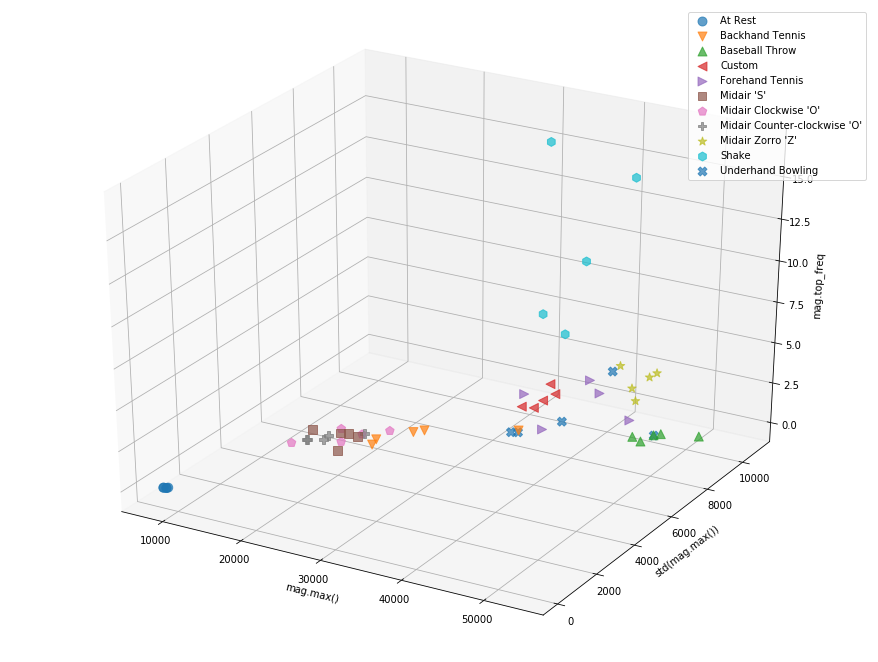

In [51]:
#TODO make this interactive
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
df_plot = filtered_df.copy()
df_plot['gesture'] = df_gesture
i = 0

x_feature_name = 'mag.max()'
y_feature_name = 'std(mag.max())'
z_feature_name = 'mag.top_freq'
x_col_idx = df.columns.get_loc(x_feature_name)
y_col_idx = df.columns.get_loc(y_feature_name)
z_col_idx = df.columns.get_loc(z_feature_name)
for grp_name, grp_idx in df_plot.groupby('gesture').groups.items():
    x = df.iloc[grp_idx,x_col_idx]
    y = df.iloc[grp_idx,y_col_idx]
    z = df.iloc[grp_idx,z_col_idx]
    ax.scatter(x, y, z, label=grp_name, marker = markers[i], s=80, alpha=0.7)  # this way you can control color/marker/size of each group freely
    i = i + 1
    
ax.legend()

ax.set_xlabel(df.columns[x_col_idx])
ax.set_ylabel(df.columns[y_col_idx])
ax.set_zlabel(df.columns[z_col_idx])